# Binary Classification with SciKitLearn
--------------------------
### Contents:
- **Background**
- **Data importing/preprocessing **
- **Feature selection and dimensionality reduction **
- **SVM classifier - **
- **Logistic regression -**
- **Random forest - **

--------------------------

### Section 1: Background 
In this assignment, your task is to build a binary classifier that can distinguish between two brain disorders - Alzheimer's (AD) and Progressive Supranuclear Palsy (PSP). We will be using gene expression data sourced by RNA sequencing (RNA-seq) the brain tissue of  participants. The study can be found at [<sup>1</sup>](#fn1).

Using RNA sequencing we can quantitatively measure which genes are activated and their expression levels. By comparing the gene expression levels of normal and mutated cells, we can identify differences that might reveal which genes are causing these mutations. These gene expression patterns can also serve as indicators to detect and differentiate similar diseases such as AD and PSP.


<span id="fn1"> <sup>1</sup> https://www.nature.com/articles/sdata201689</span>

--------------------------




### Section 2: Data importing/preprocessing

- Load the gene expression dataset and the labels into pandas dataframe. 
- Retain only 'Diagnosis' and 'ID' columns in the labels dataframe.
- Combine gene_exp and labels dataframes based on 'ID'. 
- Remove samples containing labels other than Alzheimer's ('AD') or Progressive supranuclear palsy ('PSP').
- Encode textual labels to numbers. For example 'AD' to 0 and 'PSP' to 1.

--------------------------


In [17]:
import pandas as pd
import numpy as np

# do not modify this
np.random.seed(89802024)


In [18]:
# Read the gene expression dataset (normalized_gene_expression.txt) into a dataframe
# We can use read_csv since the file is tab delimited.
gene_exp = pd.read_csv('normalized_gene_expression.txt', sep='\t')
gene_exp.head()

,ID,ENSG00000223972,ENSG00000227232,ENSG00000243485,ENSG00000268020,ENSG00000240361,ENSG00000186092,ENSG00000238009,ENSG00000239945,ENSG00000233750,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
0,11344_TCX,-2.168275,2.867350,-2.235659,-2.878004,-2.878004,-2.921482,0.972981,2.589508,2.049147,...,15.177233,8.620554,8.415900,9.195871,13.407342,13.089514,10.035159,14.350876,8.401389,9.124693
1,11316_TCX,-2.667791,2.919402,-3.118351,-2.963895,-2.963895,-2.963895,1.602722,3.196802,2.830484,...,15.177233,11.611706,11.478740,12.284014,13.527804,13.350245,12.613126,14.240878,10.760811,12.021301
2,11431_TCX,-3.391138,3.153625,-2.106056,-4.424961,-4.418319,-4.540941,1.453881,2.986039,2.836847,...,15.177233,10.502635,10.133659,11.504803,13.407342,13.138792,11.990068,14.472362,9.848741,10.852588
3,11341_TCX,-2.801722,3.269001,-1.133302,-3.118351,-3.118351,-3.175145,2.442415,3.961310,2.803290,...,14.764855,9.920577,10.133659,11.255892,13.466460,13.350245,12.182661,14.240878,9.637298,9.904126
4,11289_TCX,-0.162419,5.284041,0.250976,-2.218957,-2.218957,-2.328570,2.065006,3.218117,2.857921,...,14.764855,11.780232,11.209200,12.021301,13.350245,13.189390,12.353690,14.350876,11.722941,11.959163


In [19]:
# Read the labels for the dataset from labels.csv file

labels = pd.read_csv('labels.csv')
labels.head()

,ID,Diagnosis,RIN,3primeBias,Sex,AgeAtDeath
0,1005_TCX,AD,8.6,1.333306,0,90_or_above
1,1010_TCX,AD,8.3,1.593823,1,63
2,1015_TCX,AD,8.7,1.671713,1,77
3,1019_TCX,AD,7.8,1.402270,0,86
4,1029_TCX,AD,9.7,1.599649,0,69


In [20]:
# Drop unnecessary columns in labels dataframe

labels = labels[["ID", "Diagnosis"]]
labels.head()

,ID,Diagnosis
0,1005_TCX,AD
1,1010_TCX,AD
2,1015_TCX,AD
3,1019_TCX,AD
4,1029_TCX,AD


In [21]:
# Merge both dataframes based on column 'ID' 

df = pd.merge(gene_exp, labels, on="ID")
df["Diagnosis"].value_counts()

Diagnosis
PSP                 82
AD                  80
Control             76
Pathologic Aging    30
Name: count, dtype: int64

In [22]:
# Retain only samples having labels of 'AD' or 'PSP'

df = df[df["Diagnosis"].isin(["AD", "PSP"])]


In [23]:
# Separate the merged dataframe into features and labels. Remove 'ID' column

X = df.drop(columns=["ID", "Diagnosis"]) # features
y = df["Diagnosis"] # labels


In [24]:
# Encode textual labels in 'y' to numbers

from sklearn.preprocessing import LabelEncoder

y = y.map({'AD': 0, 'PSP': 1})
assert(np.all((y == 0) | (y == 1)))

--------------------------
### Section 3 - Feature selection and dimensionality reduction 

On analyzing the shape of the gene expression dataframe we can see that the number of features (p) is much larger than the number of observations (N). This is known as the p >> N problem, and is commonly seen in genomics and healthcare datasets.
To mitigate this problem, we will employ feature selection and dimensionality reduction techniques so that we have a more compact feature space. 


- Randomly select 100 features.
- Select top 1%  most variant features.
- Perform PCA and select principal components that account for 95% of the total explained variance.
    - Plot the first two principal components of X_projected, coloring data points by their labels. Explain if the data is linearly separable in this plot.

  
--------------------------


In [25]:
# Randomly select 100 features

X_rand = X.sample(n=100, axis=1)

assert X_rand.shape == (162, 100)

In [26]:
# Select top 1% the features with the most variance
# Since we have 100 features, the top 1% is a count of 1.

variances = X_rand.var(axis=0)
n_top = max(1, int(0.01 * X_rand.shape[1]))
top_feature = variances.nlargest(n_top).index
X_var = X_rand[top_feature]

X_var.shape

(162, 1)

In [27]:
# Use full PCA and select only components contributing to 95% total variance

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rand)
pca = PCA()
X_pca_full = pca.fit_transform(X_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.searchsorted(cumulative_variance, 0.95) + 1
X_projected = X_pca_full[:, :n_components_95]

X_projected.shape

(162, 55)

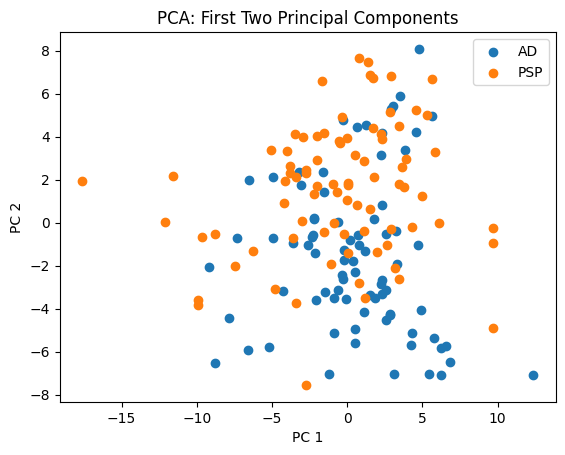

In [28]:
# Scatter plot of first two principal components 

import matplotlib.pyplot as plt 

plt.scatter(X_projected[y == 0, 0], X_projected[y == 0, 1], label='AD')
plt.scatter(X_projected[y == 1, 0], X_projected[y == 1, 1], label='PSP')
plt.title('PCA: First Two Principal Components') 
plt.xlabel('PC 1') 
plt.ylabel('PC 2') 
plt.legend() 
plt.show()

### Section 4: SVM classifier 
 

- Complete the 'evaluate_classifier' function to implement a SVM classifier. Use GridSearchCV to search for the optimal kernel and parameter C (C determines the margin width).
- Use 10-fold StratifiedKFold for cross-validation (CV) when searching. Set scoring to 'accuracy'. StratifiedKFold will divide our dataset into 10 sets, model will be trained on 9 sets and tested on 1 set. This results in 10 models, each fitted on different combinations of sets. 
- Print the best parameters and score found for each of X_rand, X_var, and X_projected after cross validation.

NOTE: We will not be doing a train-val-test split of the dataset in this assignment because of the small sample size. We will do a cross-validated train-test split for evaluations.


--------------------------


In [29]:
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, GridSearchCV


def evaluate_classifier(clf, X, y, scoring, parameters, n_splits=10):
    # Create StratifiedKFold validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    # Grid search for the two parameters (kernel, regularization parameter (inverse of margin))
    grid_search = GridSearchCV(clf, parameters, scoring=scoring, cv=skf, n_jobs=-1)
    grid_search.fit(X, y)

    # Print the best parameters and score
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

    return grid_search



parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.01, 0.1, 1, 10]}
scoring = 'accuracy'

# Intiate a SVM classifier
clf = svm.SVC()

evaluate_classifier(clf, X_rand, y, scoring, parameters)
evaluate_classifier(clf, X_var, y, scoring, parameters)
evaluate_classifier(clf, X_projected, y, scoring, parameters)

# Is X_projected performing better than the other two?

Best parameters:  {'C': 0.1, 'kernel': 'linear'}
Best score:  0.7591911764705882
Best parameters:  {'C': 1, 'kernel': 'linear'}
Best score:  0.7529411764705882
Best parameters:  {'C': 1, 'kernel': 'sigmoid'}
Best score:  0.7893382352941176


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

### Section 5: Logistic regression

We explored three basic methods for feature selection. Another approach for having fewer features is regularization. In lasso regularization, as we increase the parameter (it is called 'alpha' in sklearn), more and more coefficients of our features are shrinked to zero.

- Build logistic regression models using lasso regularization (L1 penalty) with varying alpha values.  
- We'll perform cross-validation using 'cross_validate' function to measure the performance of models. We will again use StratifiedKFold with 10 splits, but remember to get the splits on the original dataframe 'X'. 
    - Set scoring to 'accuracy'.
    - Record the mean test accuracy across CV splits for each alpha.
    - Record the mean number of non-zero coefficients across CV splits for each alpha.
- Repeat the above process but use ridge regression (l2 penalty) in logistic regression.
- Plot the number of non-zero feature coefficients recorded in both lasso and ridge regression versus alpha.  
- Plot cv accuracy recorded for both penalties versus alpha. Write two lines explaining why accuracy decreases as we increase alpha in lasso regression?

--------------------------


In [35]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
import time


alphas = np.array([0.1, 1, 10, 100, 1000])
lasso_cv_acc = []
lasso_non_zero_coeff = []
ridge_non_zero_coeff = []
ridge_cv_acc = []


# x_scaled = StandardScaler().fit_transform(X)

# Create StratifiedKFold validation of 10 splits on 'X'
skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.get_n_splits(X)

for a in alphas:
    start_time = time.time()
    print("Lasso alpha = ", a)
    print("  Starting logistic regression")
    # Instantiate a logistic regression object. Use 'saga' solver and 'l1' penalty.
    clf = LogisticRegression(solver='saga', penalty='l1', C=(1 / a), max_iter=10000, warm_start=True, n_jobs=-1)
    
    # Read on how parameter 'C' and 'alpha' are related in logistic regression
    # C and a are inversely related

    # Perform cross validation as described above.
    print("  Performing cross validation")
    results = cross_validate(clf, X, y, cv=skf, scoring='accuracy', return_estimator=True, n_jobs=-1)

    # Record mean of test_score of all 10 models.
    print("  Recording mean CV accuracy")
    lasso_cv_acc.append(results['test_score'].mean())
    
    # Record mean of number of non-zero coefficients of all 10 models
    print("  Recording mean number of non-zero coefficients")
    lasso_non_zero_coeff.append(results['estimator'][0].coef_.nonzero()[0].size)

    print("  Time taken: ", time.time() - start_time)


for a in alphas:
    start_time = time.time()
    print("Ridge alpha = ", a)
    # Repeat the above but with 'l2' penalty
    clf = LogisticRegression(solver='saga', penalty='l2', C=(1 / a), max_iter=10000, warm_start=True, n_jobs=-1)
    results = cross_validate(clf, X, y, cv=skf, scoring='accuracy', return_estimator=True, n_jobs=-1)
    ridge_cv_acc.append(results['test_score'].mean())
    ridge_non_zero_coeff.append(results['estimator'][0].coef_.nonzero()[0].size)
    print("  Time taken: ", time.time() - start_time)



Lasso alpha =  0.1
  Starting logistic regression
  Performing cross validation
  Recording mean CV accuracy
  Recording mean number of non-zero coefficients
  Time taken:  1730.9396295547485
Lasso alpha =  1.0
  Starting logistic regression
  Performing cross validation
  Recording mean CV accuracy
  Recording mean number of non-zero coefficients
  Time taken:  2608.591906785965
Lasso alpha =  10.0
  Starting logistic regression
  Performing cross validation
  Recording mean CV accuracy
  Recording mean number of non-zero coefficients
  Time taken:  2318.6953270435333
Lasso alpha =  100.0
  Starting logistic regression
  Performing cross validation
  Recording mean CV accuracy
  Recording mean number of non-zero coefficients
  Time taken:  15.602684497833252
Lasso alpha =  1000.0
  Starting logistic regression
  Performing cross validation
  Recording mean CV accuracy
  Recording mean number of non-zero coefficients
  Time taken:  3.2466163635253906
Ridge alpha =  0.1
  Time taken:  7

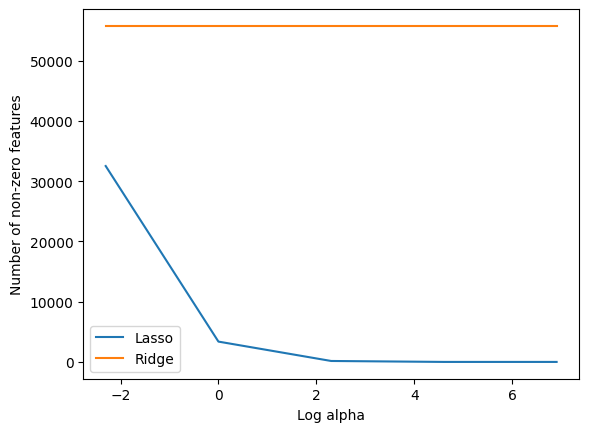

In [36]:
# Plot log of alpha vs number of non-zero features.

import matplotlib.pyplot as plt


plt.xlabel('Log alpha')
plt.ylabel('Number of non-zero features')
plt.plot(np.log(alphas), lasso_non_zero_coeff, label='Lasso')
plt.plot(np.log(alphas), ridge_non_zero_coeff, label='Ridge')
plt.legend(loc="lower left")
plt.show()


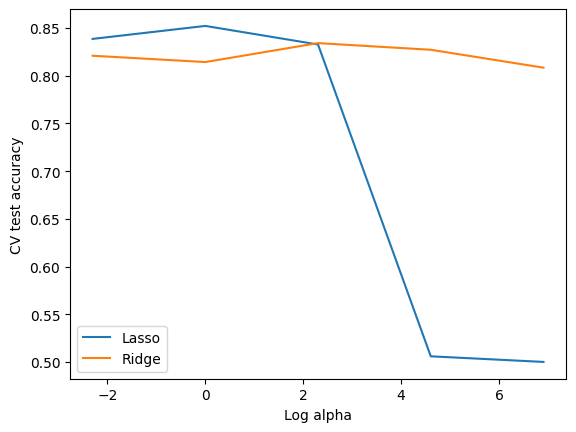

In [37]:
# Plot log of alpha vs mean CV test accuracy. 

plt.xlabel('Log alpha')
plt.ylabel('CV test accuracy')
plt.plot(np.log(alphas), lasso_cv_acc, label='Lasso')
plt.plot(np.log(alphas), ridge_cv_acc, label='Ridge')
plt.legend(loc="lower left")
plt.show()

# Write two lines below on why accuracy is decreasing in lasso?
# Lasso sparsity is aggressive, so with a larger alpha (smaller C) there are more weights driven to zero as seen in the above graph.
# This is essentially underfitting, where the model does not find the useful weights within the noise.

### Section 6: Random forest  
 
In this section, we will implement a random forest algorithm on X_projected (i.e., the data reduced using PCA). We will vary the number of trees and features considered when splitting nodes. 

-  Build random forest models with varying tree counts and features to consider when looking for the split.
-  Perform similar cross-validate with stratified folds, as in Section 5..
-  Record accuracies obtained for the test set for each hyperparameter combination.
-  Plot test accuracy vs tree count for each #features (m, m//2, sqrt(m)) we are using.
-  Repeat the above using just the first 25 components of X_projected.
--------------------------


In [38]:
from sklearn.ensemble import RandomForestClassifier

X_rf = X_projected

num_trees = [1, 50, 100, 200, 300, 500, 1000]
m =  X_rf.shape[1]
max_features = [ m, m//2, 'sqrt']
test_accs = []

# Create StratifiedKFold validation
skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.get_n_splits(X_rf)

for features in max_features:
    print("Number of features: ", features)
    f_test_accs = []
    for tree in num_trees:
        print("  Number of trees: ", tree)
        # Instantiate a random forest object. Set max_depth=5.
        rf = RandomForestClassifier(n_estimators=tree, max_features=features, max_depth=5, n_jobs=-1)

        # Perform cross validation
        print("    Performing cross validation")
        results = cross_validate(rf, X_rf, y, cv=skf, scoring='accuracy', return_estimator=True, n_jobs=-1)

        # Record the mean of CV test scores
        print("    Recording mean CV accuracy")
        f_test_accs.append(results['test_score'].mean())
    test_accs.append(f_test_accs)


Number of features:  55
  Number of trees:  1
    Performing cross validation
    Recording mean CV accuracy
  Number of trees:  50
    Performing cross validation
    Recording mean CV accuracy
  Number of trees:  100
    Performing cross validation
    Recording mean CV accuracy
  Number of trees:  200
    Performing cross validation
    Recording mean CV accuracy
  Number of trees:  300
    Performing cross validation
    Recording mean CV accuracy
  Number of trees:  500
    Performing cross validation
    Recording mean CV accuracy
  Number of trees:  1000
    Performing cross validation
    Recording mean CV accuracy
Number of features:  27
  Number of trees:  1
    Performing cross validation
    Recording mean CV accuracy
  Number of trees:  50
    Performing cross validation
    Recording mean CV accuracy
  Number of trees:  100
    Performing cross validation
    Recording mean CV accuracy
  Number of trees:  200
    Performing cross validation
    Recording mean CV accuracy


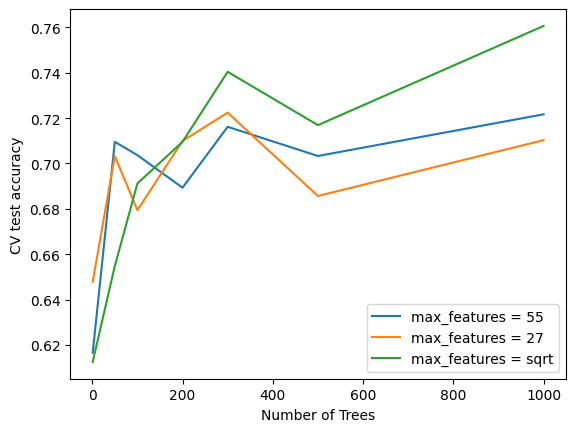

In [34]:
# Plot CV test accuracy vs number of trees 

plt.xlabel('Number of Trees')
plt.ylabel('CV test accuracy')
for i, max_feat in enumerate(max_features):
    plt.plot(num_trees, test_accs[i] , label="max_features = "+str(max_feat))
plt.legend(loc="lower right")

plt.show()


#### Section 6.1: What are your observations in the plot above?

In [ ]:
"""
The plot above shows that as the number of trees increases, the general accuracy of each of the models increases.
Additionally, the overall accuracy seems to improve with fewer max features. Since the input set of features we are
using is X_projected, we are theoretically limiting the feature set to the most variant of the data set. So, as we
trim down to even fewer features, the model is trained on data that is ensured to be variant across classifications,
allowing it to find the boundaries of fit more easily.
"""